# Logistic Regression

In [17]:
import pandas as pd

df = pd.read_csv("Default.csv")
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,10000.0,835.374886,483.714985,0.000000,481.731105,823.636973,1166.308386,2654.322576
income,10000.0,33516.981876,13336.639563,771.967729,21340.462903,34552.644802,43807.729272,73554.233495


In [7]:
df["default"].value_counts()

# unbalanced dataset - mostly not default

default
No     9667
Yes     333
Name: count, dtype: int64

<Axes: xlabel='balance', ylabel='income'>

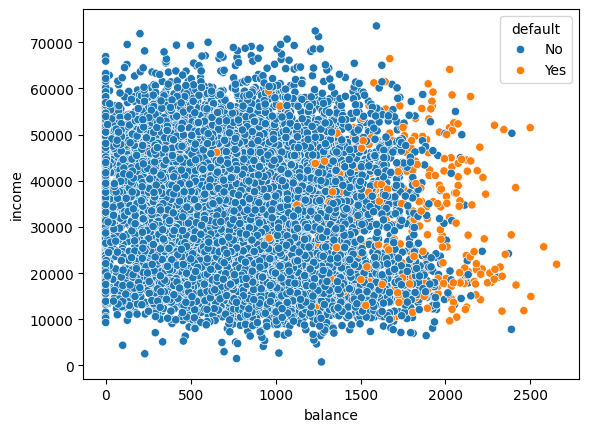

In [11]:
import seaborn as sns

sns.scatterplot(data=df, x="balance", y="income", hue="default")

<Axes: xlabel='default', ylabel='balance'>

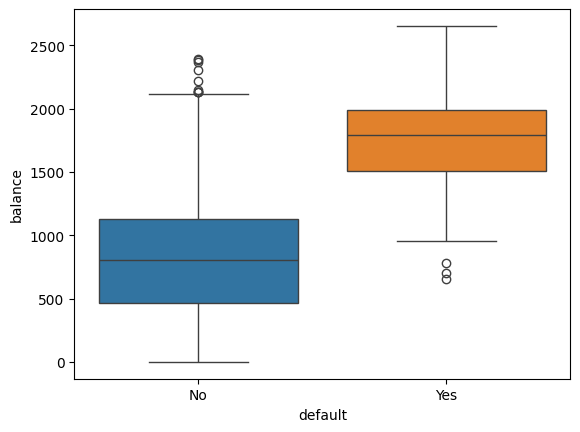

In [15]:
sns.boxplot(data=df, x="default", y="balance", hue="default")

# Dummy encoding

- categorical features -> represent with 1 and 0
- categorical features: default and student

In [19]:
df_dummies = pd.get_dummies(df, columns=["default", "student"], drop_first=True).astype(
    int
)
df_dummies.head()

,balance,income,default_Yes,student_Yes
0,729,44361,0,0
1,817,12106,0,1
2,1073,31767,0,0
3,529,35704,0,0
4,785,38463,0,0


# Scikit-learn steps

## 0. divide features and labels

In [20]:
X, y = df_dummies.drop("default_Yes", axis=1), df_dummies["default_Yes"]
X.head()

,balance,income,student_Yes
0,729,44361,0
1,817,12106,1
2,1073,31767,0
3,529,35704,0
4,785,38463,0


In [21]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: default_Yes, dtype: int64

## 1. train|test split

In [23]:
from sklearn.model_selection import train_test_split


# help(train_test_split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((6700, 3), (3300, 3))

a quick check to see that we have both yes and no in default in both train and test


In [24]:
y_train.value_counts()

default_Yes
0    6477
1     223
Name: count, dtype: int64

In [25]:
y_test.value_counts()

default_Yes
0    3190
1     110
Name: count, dtype: int64

## 2. Scale dataset

Feature standardization -> scale to standard normal distribution
$z = \frac{x-\mu}{\sigma}$

- 0 mean
- 1 standard deviation

In [31]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

print(f"{scaled_X_train.mean() = }") #0
print(f"{scaled_X_train.std() = }")
print(f"{scaled_X_test.mean() = }")
print(f"{scaled_X_test.std() = }")


scaled_X_train.mean() = np.float64(-6.044915811690405e-17)
scaled_X_train.std() = np.float64(1.0)
scaled_X_test.mean() = np.float64(-0.005465691178512372)
scaled_X_test.std() = np.float64(0.987090782800369)


## 3. Training - Logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# penalty None -> logistic regression without regularization
model = LogisticRegression(C = np.inf) 
model.fit(scaled_X_train, y_train) 
model.intercept_, model.coef_

(array([-6.36112424]), array([[ 2.88786247,  0.00617815, -0.29000691]]))

## 4. Prediction of test data

In [37]:
# column 0: default NO
# column 1: default YES

y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_probability

array([[9.30429522e-01, 6.95704784e-02],
       [9.98552308e-01, 1.44769210e-03],
       [9.99985331e-01, 1.46685012e-05],
       ...,
       [9.99735808e-01, 2.64192019e-04],
       [2.67187359e-01, 7.32812641e-01],
       [9.97647640e-01, 2.35236012e-03]], shape=(3300, 2))

- $9.3e-01 = 9.3 \cdot 10^{-1} = 0.93$
- $6.96e-02 = 6.96 \cdot 10^{-2} = 0.0696$


In [40]:
y_pred = model.predict(scaled_X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0], shape=(3300,))

## 5. Evaluation of model

- confusion matrix
- evaluations metrics


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3190
           1       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



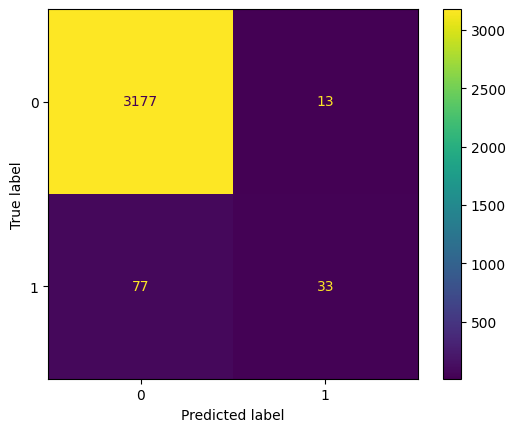

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=model.classes_)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

print(classification_report(y_test, y_pred))